## Exercise 2
#### a)
 We used Scipy's implementation of the median filter (https://docs.scipy.org/doc/scipy-1.11.4/reference/generated/scipy.ndimage.median_filter.html). The value for "size" parameter was chosen empirically by testing and comparing to the example image from the assignment.

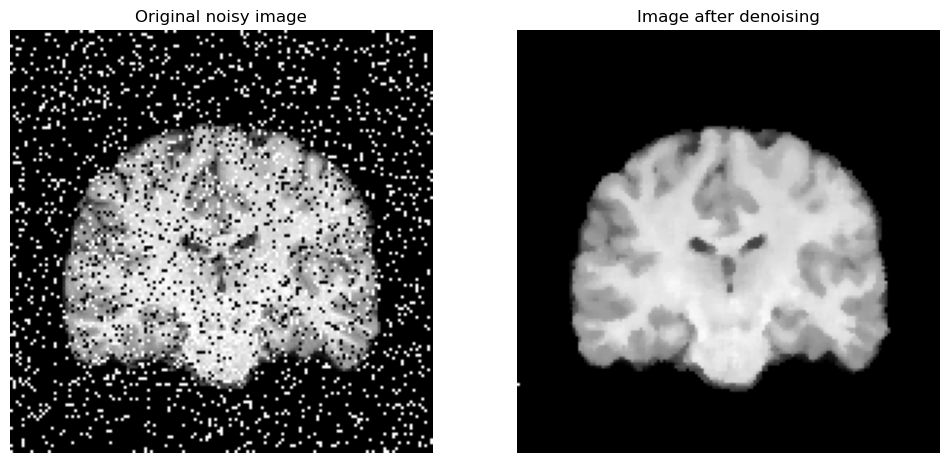

In [147]:
from skimage import io, img_as_float
from scipy import ndimage
import matplotlib.pyplot as plt

image = img_as_float(io.imread('brain-noisy.png'))
denoised = ndimage.median_filter(image, size=4)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(image,cmap="gray")
plt.title("Original noisy image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(denoised, cmap="gray")
plt.title("Image after denoising")
plt.axis("off")
plt.show()

### b) 
Looking at the log-scaled histogram we can see 4 distinct peaks. The peak near 0 is probably the background values that were included in the mask (our mask looks to cover a larger area than the denoised image brain). Looking at the other peaks we come up with the intensity value ranges as:   

CSF : 0.05-0.5  
Gray matter(GM): 0.5-0.75  
white matter(WM): 0.75-1

There is defintely overlap between these ranges in the actual values but this is the estimate we could come up with just from looking at the histogram.  
To estimate the mixing weights, we used a very rough calculation of area under the curve. For this matter we decided a non-log scaled histogram would be more useful to find the heights. For this we just use area of a rectangle with width=the intensitiy range and height=visually average count. Therefore using the assumptions :  

CSF -> width=0.45   height=10  area=4.5  
GM -> width=0.25   height=70  area=17.5  
WM -> width=0.25   height=120  area=30

This gives:  
CSF = 4.5/52 = 0.086  
GM = 17.5/52 = 0.34  
WM = 30/52 = 0.57

We approximate mixing weights (to sum=1):  
Pi_csf=0.09  
Pi_GM=0.34  
Pi_WM=0.57


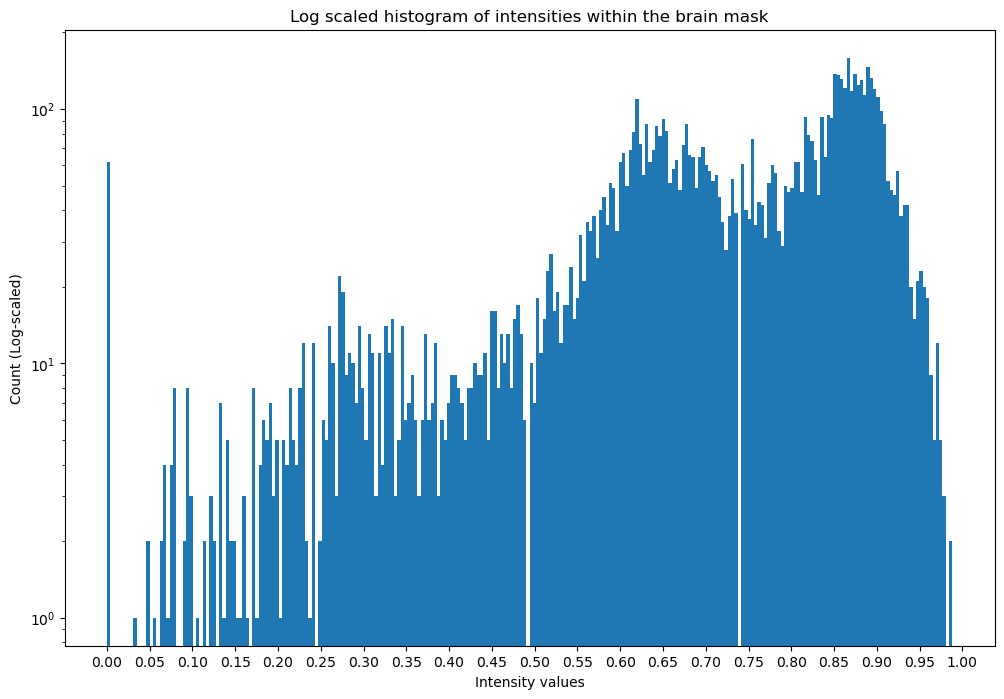

In [148]:
import numpy as np
from matplotlib.ticker import MultipleLocator

mask_image=io.imread("mask.png")
mask= mask_image > 0 
brain_vals = denoised[mask]
plt.figure(figsize=(12,8))
plt.hist(brain_vals,bins=256)
plt.yscale('log')
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.05)) 
plt.title("Log scaled histogram of intensities within the brain mask")
plt.xlabel("Intensity values")
plt.ylabel("Count (Log-scaled)")
plt.show() 

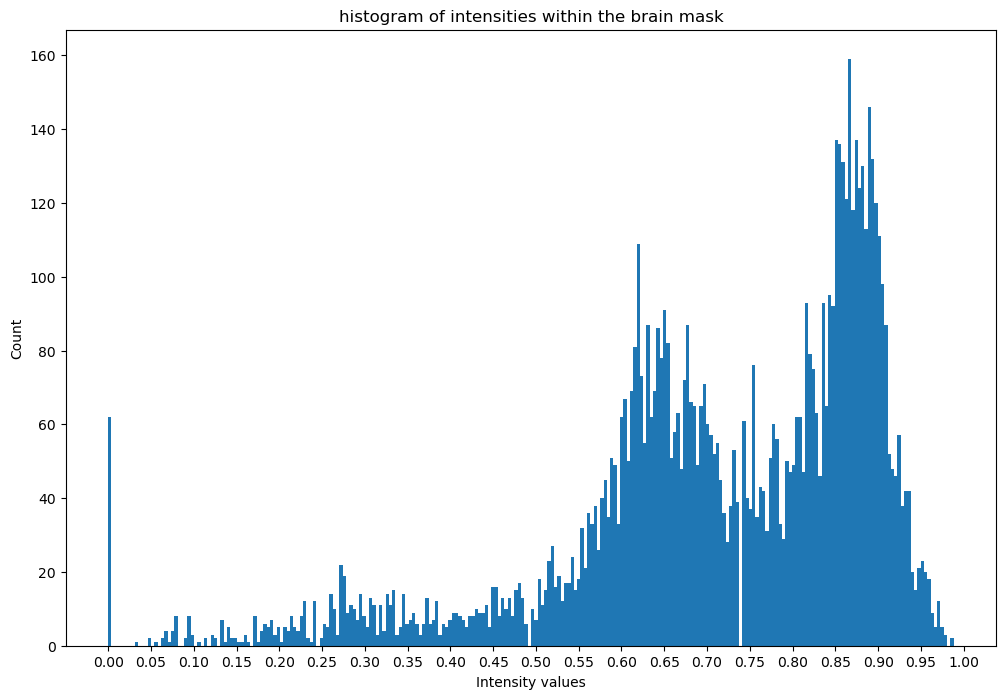

In [149]:
plt.figure(figsize=(12,8))
plt.hist(brain_vals,bins=256)
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(0.05)) 
plt.title("histogram of intensities within the brain mask")
plt.xlabel("Intensity values")
plt.ylabel("Count")
plt.show() 

### C)

The mixing weights were already estimated in b.  
to estimate mean we just visually choose the intensity values where the peaks are visible:  

mean_CSF : 0.27  
mean_Gray matter(GM): 0.63  
mean_white matter(WM): 0.87

to estimate variance we use the 68-95-99 rule of normal distribution. We assume that the tails of the distributions are overlapping so we use the estimate that the range values of each group should fall within 2 sigma of the mean from both side so 4 sigma overall. Using the ranges from b and the estimated means we get:  


var_CSF : (0.45/4)^2 = (0.1125)^2 = 0.0126  
var_Gray matter(GM): (0.25/4)^2 = (0.0625)^2 = 0.0039  
var_white matter(WM): (0.25/4)^2 = (0.0625)^2 = 0.0039


In [156]:
N = brain_vals.shape[0]
K = 3 
responsibility = np.zeros((N, K), dtype=float)
means = np.array([0.27, 0.63, 0.87], dtype=float)
vars  = np.array([0.0126, 0.0039, 0.0039], dtype=float)
mix   = np.array([0.09, 0.34, 0.57],  dtype=float)

def normal_pdf(x, mu, var): # this is N(xi | mu_k, var_k)
    return (1.0 / np.sqrt(2.0 * np.pi * var)) * np.exp(-0.5 * (x - mu) ** 2 / var)

def E_step(img_data, responsibility):
    for i in range(N):             
        x_i = img_data[i]
        denominator = 0
        for k in range(K):
            denominator += mix[k] * normal_pdf(x_i, means[k], vars[k])
        for k in range(K):
            numerator = mix[k] * normal_pdf(x_i, means[k], vars[k])
            responsibility[i, k] = numerator / denominator

E_step(brain_vals, responsibility)
print(responsibility)

[[1.00000000e+00 9.75738846e-21 1.47696033e-40]
 [1.00000000e+00 9.75738846e-21 1.47696033e-40]
 [1.00000000e+00 9.75738846e-21 1.47696033e-40]
 ...
 [9.99947271e-01 5.27290141e-05 3.99094198e-16]
 [9.99947271e-01 5.27290141e-05 3.99094198e-16]
 [9.99992790e-01 7.20961796e-06 1.28261208e-17]]


### d)

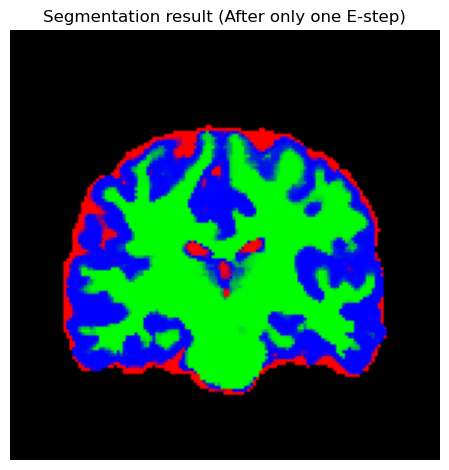

In [ ]:
H, W = denoised.shape
result= np.zeros((H, W, 3), dtype=float)  #the 3rd dimension is for rgb so heigh x weight x rgb
result[..., 0][mask] = responsibility[:, 0]  
result[..., 2][mask] = responsibility[:, 1]  
result[..., 1][mask] = responsibility[:, 2]  
plt.figure()
plt.imshow(result)
plt.title("Segmentation result (After only one E-step)")
plt.axis("off")
plt.tight_layout()
plt.show()

### e)

In [158]:
def M_step(img_data,responsibility):
    for k in range(K):
        num_mu=0
        num_var=0
        N_k=0
        for i in range(N):
            num_mu += responsibility[i,k]*img_data[i]
            
            N_k += responsibility[i,k]
        mean=num_mu/N_k
        means[k]=mean
        mix[k]=N_k/N
        for i in range(N):
            num_var += responsibility[i,k]*pow((img_data[i] - mean),2)
        vars[k]=num_var/N_k
    

M_step(brain_vals,responsibility)
print("re-computed means:", np.round(means, 3))
print("re-computed variances:", np.round(vars, 3))
print("re-computed mixing weights:", np.round(mix, 3))

re-computed means: [0.288 0.637 0.854]
re-computed variances: [0.019 0.004 0.003]
re-computed mixing weights: [0.095 0.39  0.515]


### f)

We really couldn't figure out why our final segmentation is not as smooth as the example picture in the assignment. There are more red (CSF) patches in the blue (GM) area. We even lowered the tolerance and ran it for longer until convergence but no immediate improvements. It might be due to our initiliziation values.

In [159]:
N = brain_vals.shape[0]
K = 3 
responsibility = np.zeros((N, K), dtype=float)
means = np.array([0.27, 0.63, 0.87], dtype=float)
vars  = np.array([0.0126, 0.0039, 0.0039], dtype=float)
mix   = np.array([0.09, 0.34, 0.57],  dtype=float)
max_iter = 500
tol = 1e-10

for iter in range(max_iter):
    old_means = means.copy()
    old_vars  = vars.copy()
    old_mix   = mix.copy()
    E_step(brain_vals, responsibility)
    M_step(brain_vals, responsibility)

    diff_means = np.max(np.abs(means - old_means))
    diff_vars  = np.max(np.abs(vars  - old_vars))
    diff_mix   = np.max(np.abs(mix   - old_mix))
    diff = max(diff_means, diff_vars, diff_mix)

    print(f"Iter {iter:02d}")

    if diff < tol:
        print("Converged.")
        break

Iter 00
Iter 01
Iter 02
Iter 03
Iter 04
Iter 05
Iter 06
Iter 07
Iter 08
Iter 09
Iter 10
Iter 11
Iter 12
Iter 13
Iter 14
Iter 15
Iter 16
Iter 17
Iter 18
Iter 19
Iter 20
Iter 21
Iter 22
Iter 23
Iter 24
Iter 25
Iter 26
Iter 27
Iter 28
Iter 29
Iter 30
Iter 31
Iter 32
Iter 33
Iter 34
Iter 35
Iter 36
Iter 37
Iter 38
Iter 39
Iter 40
Iter 41
Iter 42
Iter 43
Iter 44
Iter 45
Iter 46
Iter 47
Iter 48
Iter 49
Iter 50
Iter 51
Iter 52
Iter 53
Iter 54
Iter 55
Iter 56
Iter 57
Iter 58
Iter 59
Iter 60
Iter 61
Iter 62
Iter 63
Iter 64
Iter 65
Iter 66
Iter 67
Iter 68
Iter 69
Iter 70
Iter 71
Iter 72
Iter 73
Iter 74
Iter 75
Iter 76
Iter 77
Iter 78
Iter 79
Iter 80
Iter 81
Iter 82
Iter 83
Iter 84
Iter 85
Iter 86
Iter 87
Iter 88
Iter 89
Iter 90
Iter 91
Iter 92
Iter 93
Iter 94
Iter 95
Iter 96
Iter 97
Iter 98
Iter 99
Iter 100
Iter 101
Iter 102
Iter 103
Iter 104
Iter 105
Iter 106
Iter 107
Iter 108
Iter 109
Iter 110
Iter 111
Iter 112
Iter 113
Iter 114
Iter 115
Iter 116
Iter 117
Iter 118
Iter 119
Iter 120
Iter 121
It

final means: [0.351 0.668 0.871]
final variances: [0.031 0.006 0.002]
final mixing weights: [0.12  0.455 0.425]


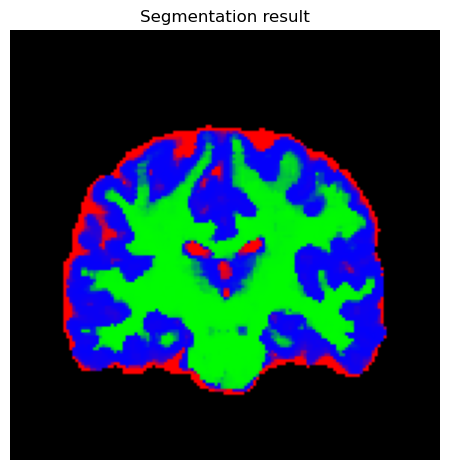

In [ ]:
print("final means:", np.round(means, 3))
print("final variances:", np.round(vars, 3))
print("final mixing weights:", np.round(mix, 3))
H, W = denoised.shape
result= np.zeros((H, W, 3), dtype=float)  
result[..., 0][mask] = responsibility[:, 0]  
result[..., 2][mask] = responsibility[:, 1]  
result[..., 1][mask] = responsibility[:, 2]  
plt.figure()
plt.imshow(result)
plt.title("Segmentation result")
plt.axis("off")
plt.tight_layout()
plt.show()